# Imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
from glob import glob
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr, spearmanr

import warnings
warnings.filterwarnings("ignore")

In [3]:
from data_transformation import CleanData
from features_library import FeatureTransformations

# Load Data

In [4]:
DIR_CRYPTO_DATA = "./data/1_Crypto_data/"
DIR_FINANCIAL_DATA = "./data/1_Financial_component_data/"

In [5]:
dict_assets = {}
for file_crypto in glob(f"{DIR_CRYPTO_DATA}*.csv"):

    # Read CSV
    asset_name = os.path.basename(file_crypto).split(".")[0]
    df_asset = pd.read_csv(file_crypto)

    # Pre-Process Data
    preproc = CleanData(df_asset)
    preproc.make_datetime_index(date_col='Date')
    preproc.resample(freq='1D')
    preproc.strip_column_name()

    # assign to dict
    dict_assets[asset_name] = preproc.df


In [6]:
df_asset.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [7]:
dict_fd = {}
for file_fd in glob(f"{DIR_FINANCIAL_DATA}*.csv"):

    # Read CSV
    fd_name = os.path.basename(file_fd).split(".")[0]
    df_fd = pd.read_csv(file_fd)

    # Pre-Process Data
    preproc = CleanData(df_fd)
    preproc.make_datetime_index(date_col='Date')
    preproc.resample(freq='1D')
    preproc.strip_column_name()

    # Keep??
    # if ('Adj Close' not in df_fd.columns) and ('Close' in df_fd.columns):
    #     df_fd['Adj Close'] = df_fd['Close'].copy()

    # assign to dict
    dict_fd[fd_name] = preproc.df


In [9]:
df_risk_free = pd.read_excel(os.path.join(DIR_FINANCIAL_DATA, "RiskFree.xls"))
df_risk_free.index = df_risk_free['TcmDate']
df_risk_free.index.name = None
df_risk_free = df_risk_free[['Tcm1mo', 'Tcm3mo', 'Tcm1yr', 'Tcm5yr', 'Tcm10yr']]
df_risk_free = df_risk_free.resample('1D').first().ffill()
df_risk_free

Tcm1mo  Tcm3mo  Tcm1yr  Tcm5yr  Tcm10yr
1997-01-02  0.0519  0.0519  0.0563  0.0630   0.0654
1997-01-03  0.0517  0.0517  0.0560  0.0628   0.0652
1997-01-04  0.0517  0.0517  0.0560  0.0628   0.0652
1997-01-05  0.0517  0.0517  0.0560  0.0628   0.0652
1997-01-06  0.0517  0.0517  0.0561  0.0630   0.0654
...            ...     ...     ...     ...      ...
2023-03-16  0.0422  0.0474  0.0449  0.0372   0.0356
2023-03-17  0.0431  0.0452  0.0426  0.0344   0.0339
2023-03-18  0.0431  0.0452  0.0426  0.0344   0.0339
2023-03-19  0.0431  0.0452  0.0426  0.0344   0.0339
2023-03-20  0.0434  0.0481  0.0434  0.0356   0.0347

[9574 rows x 5 columns]

# Feature Engineering

## Make Feature Transformations

For Assets, apply all feature transformations

In [10]:
for asset in dict_assets:
    feature_transformer = FeatureTransformations(dict_assets[asset])
    feature_transformer.transform_assets()
    dict_assets[asset] = feature_transformer.df_asset

For S&P500, apply selected feature transformations

In [11]:
dict_fd['S_P 500 index']['Volume'] = np.nan
dict_fd['S_P 500 index'] = dict_fd['S_P 500 index'].ffill()
feature_transformer = FeatureTransformations(dict_fd['S_P 500 index'])
feature_transformer.transform_snp500()
dict_fd['S_P 500 index'] = feature_transformer.df_asset
dict_fd['S_P 500 index'].drop(columns=['Volume'], inplace=True)

## Add Financial Data to assets

In [12]:
for asset_name, df_asset in dict_assets.items():
    
    ASSET_START_PERIOD = df_asset.index.min()
    ASSET_END_PERIOD = df_asset.index.max()

    for financial_dataset, df_fd in dict_fd.items():

        df_fd = df_fd[ASSET_START_PERIOD:ASSET_END_PERIOD]
        
        rename_fd_cols = {column: f"{financial_dataset}_{column}".replace(" ", "_") for column in df_fd.columns}
        df_fd.rename(columns=rename_fd_cols, inplace=True)
        df_asset = pd.concat([df_asset, df_fd], axis=1)
    
    # add risk-free info
    df_asset = pd.concat([df_asset, df_risk_free[ASSET_START_PERIOD:ASSET_END_PERIOD]], axis=1)
    
    dict_assets[asset_name] = df_asset

## Normalize Features

In [26]:
for asset_name, df_asset in dict_assets.items():
    scaler = StandardScaler()
    df_asset[df_asset.columns] = scaler.fit_transform(df_asset)
    dict_assets[asset_name] = df_asset

# EDA Plots

## Describe Price Movements

Plot of close price trends with high-low indicators

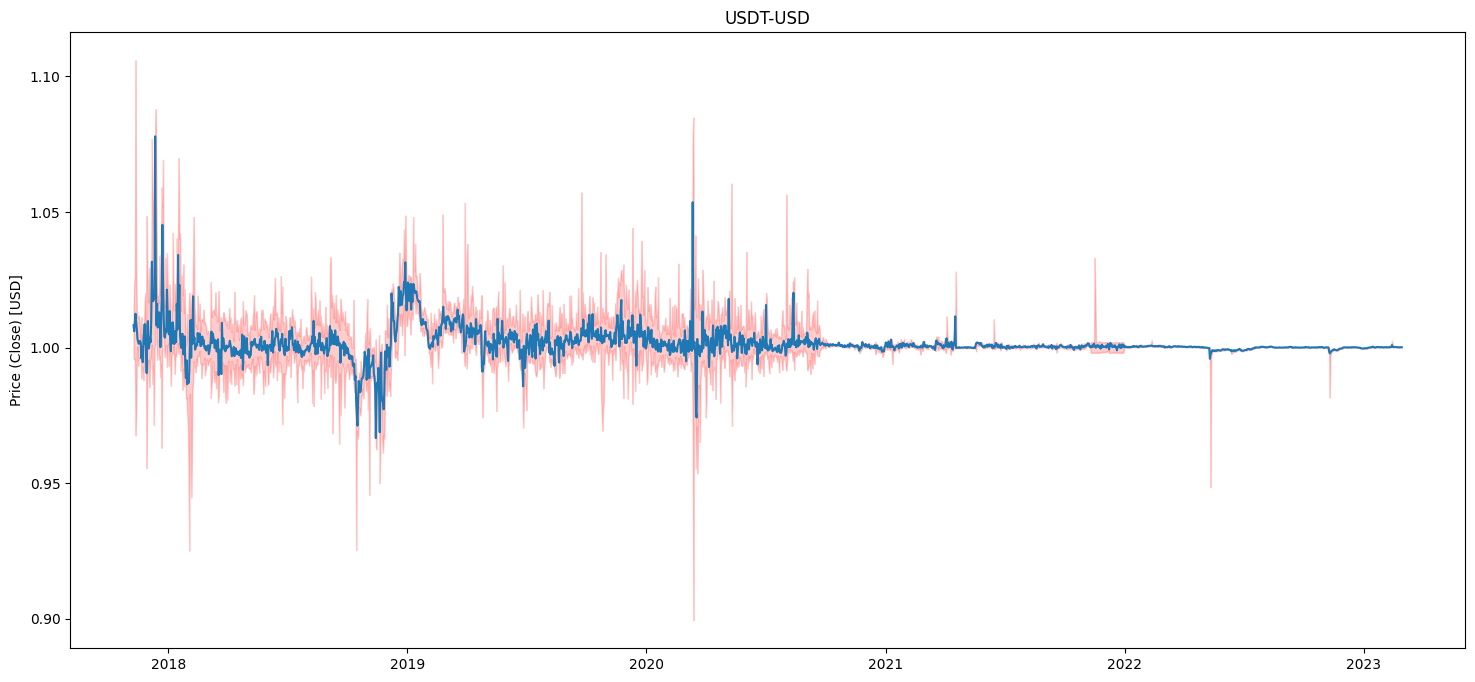

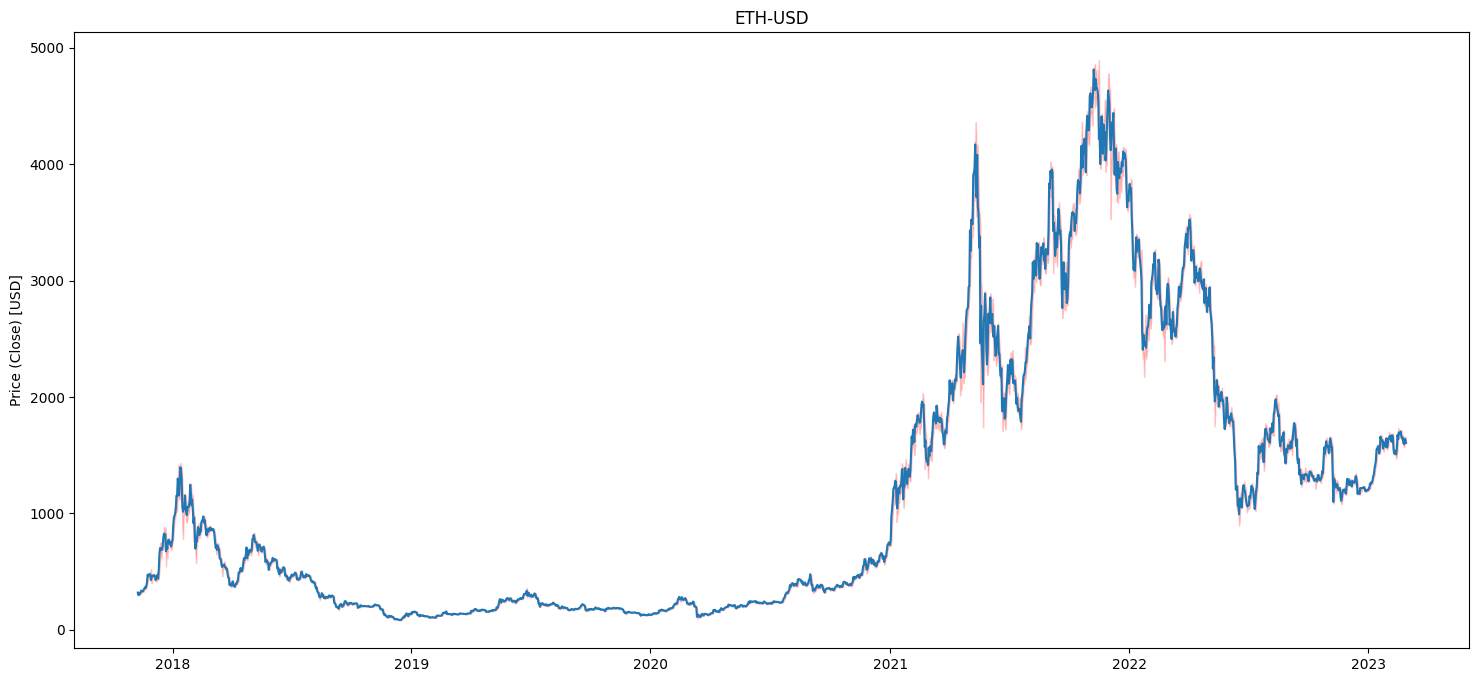

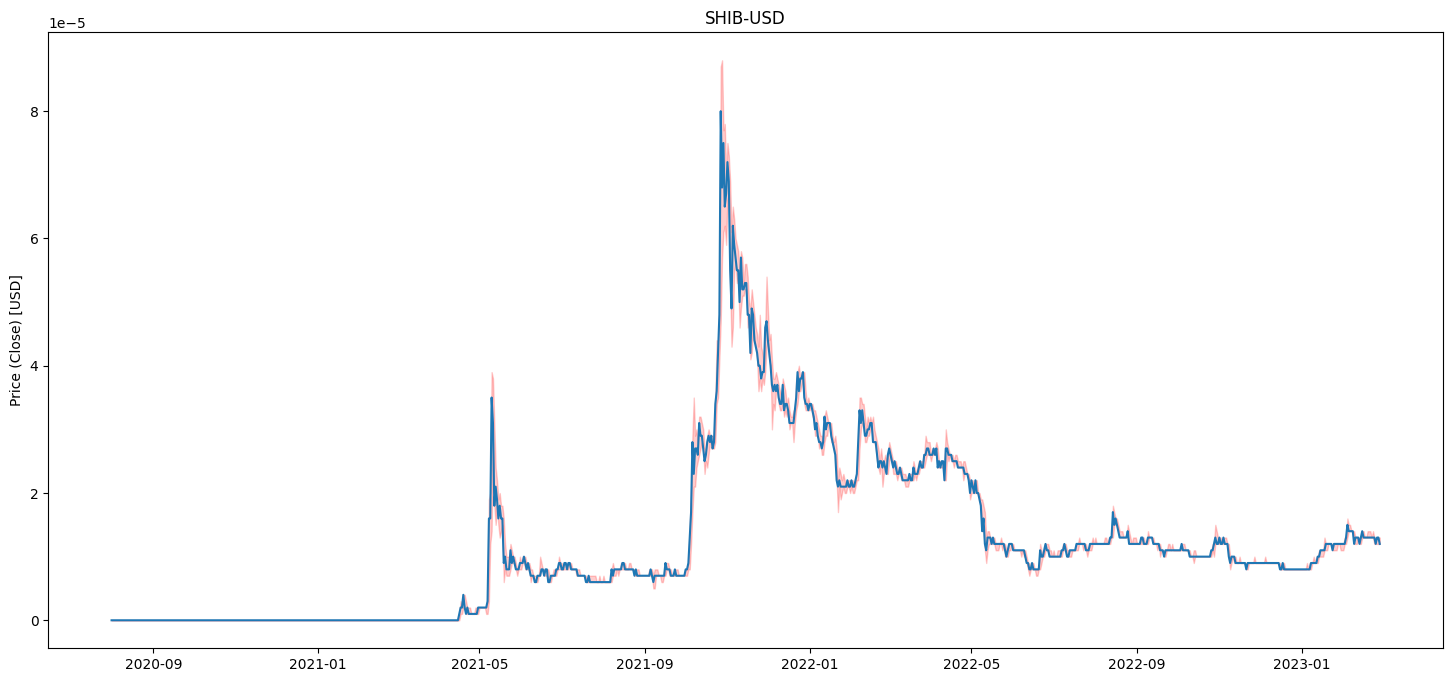

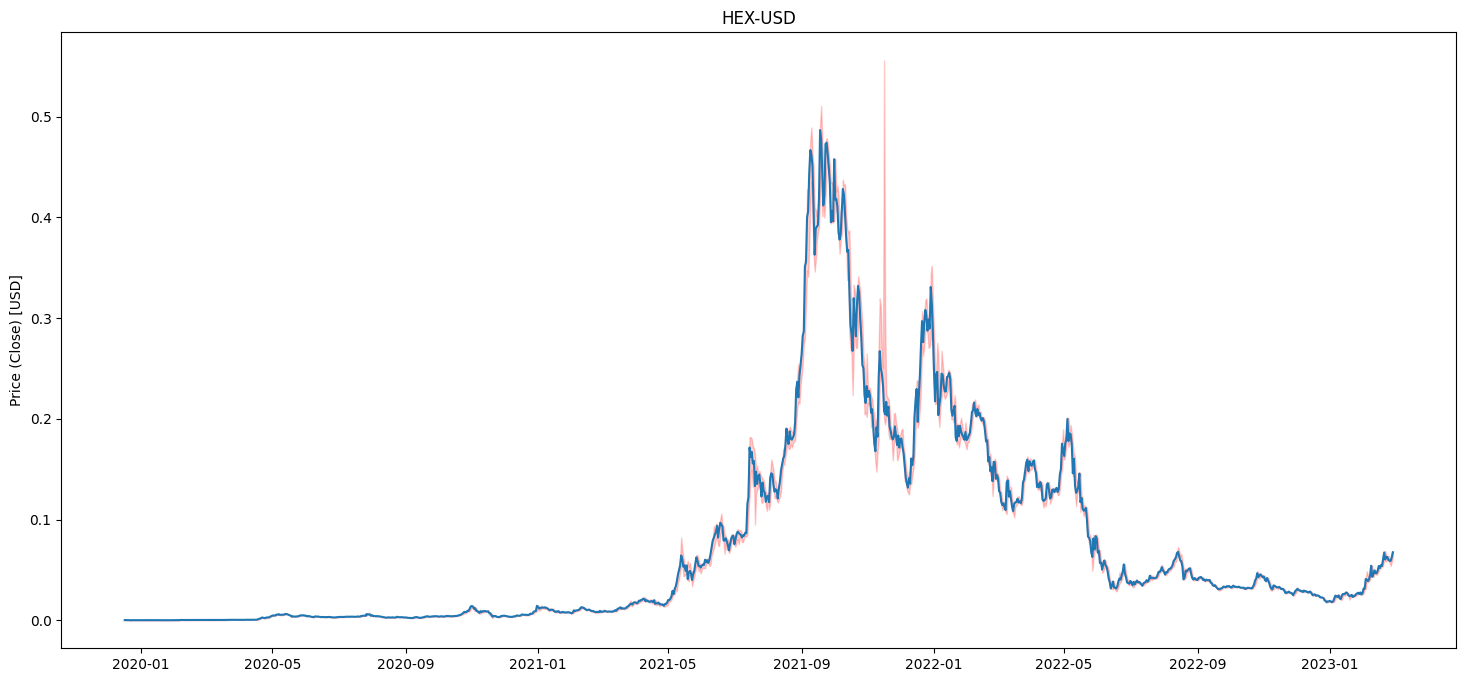

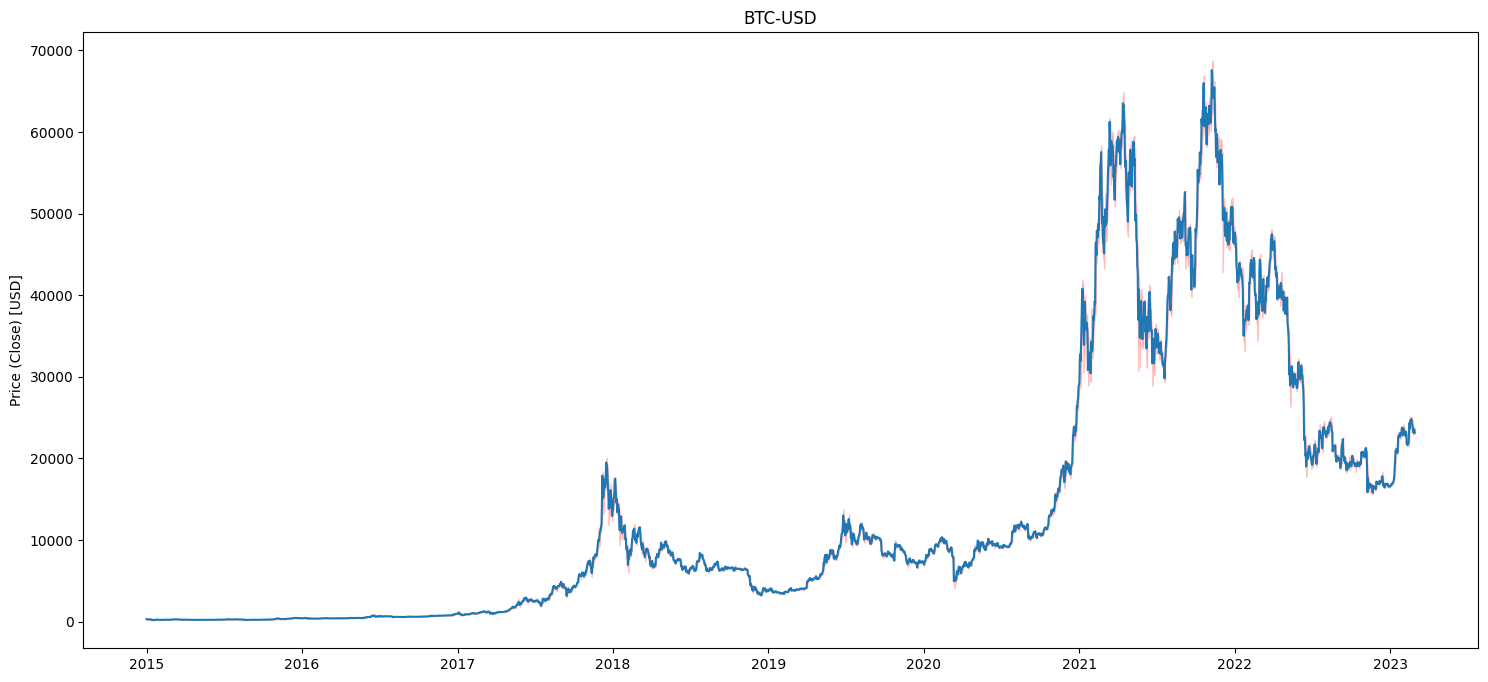

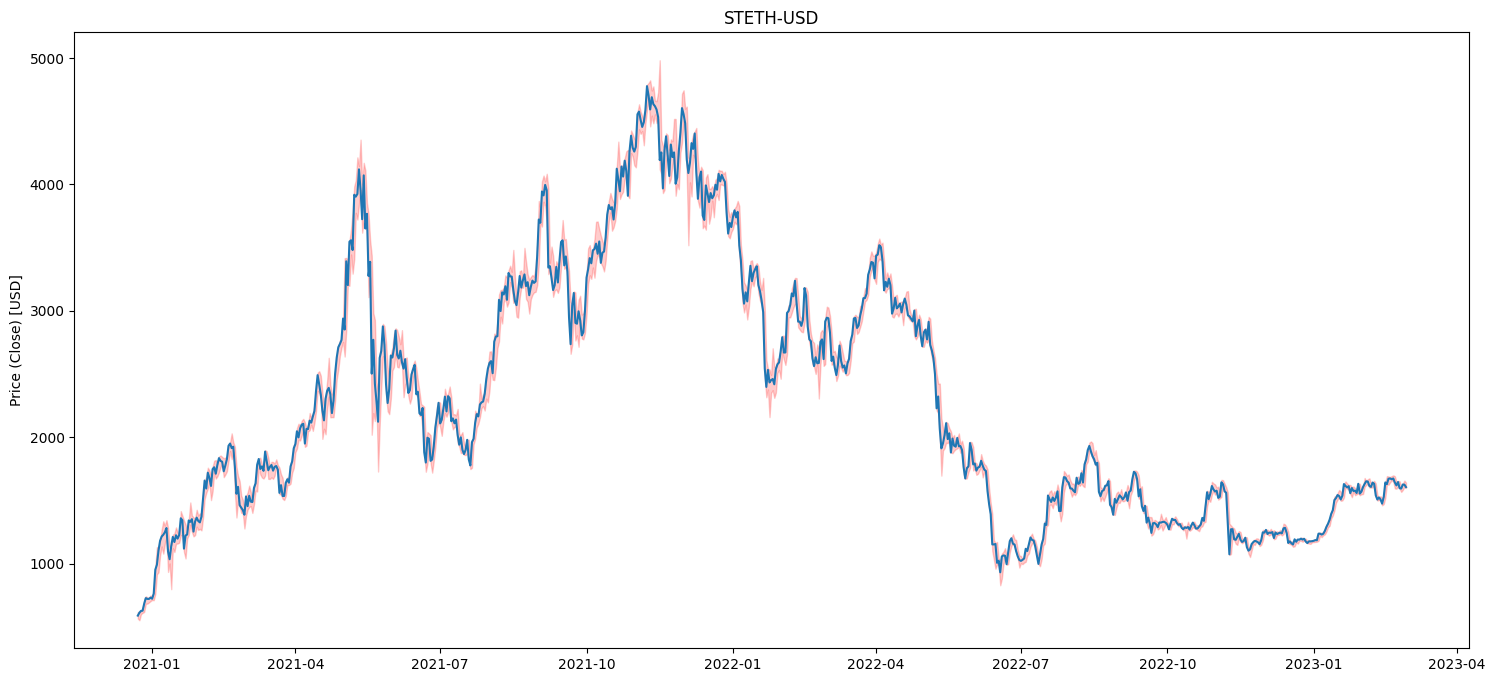

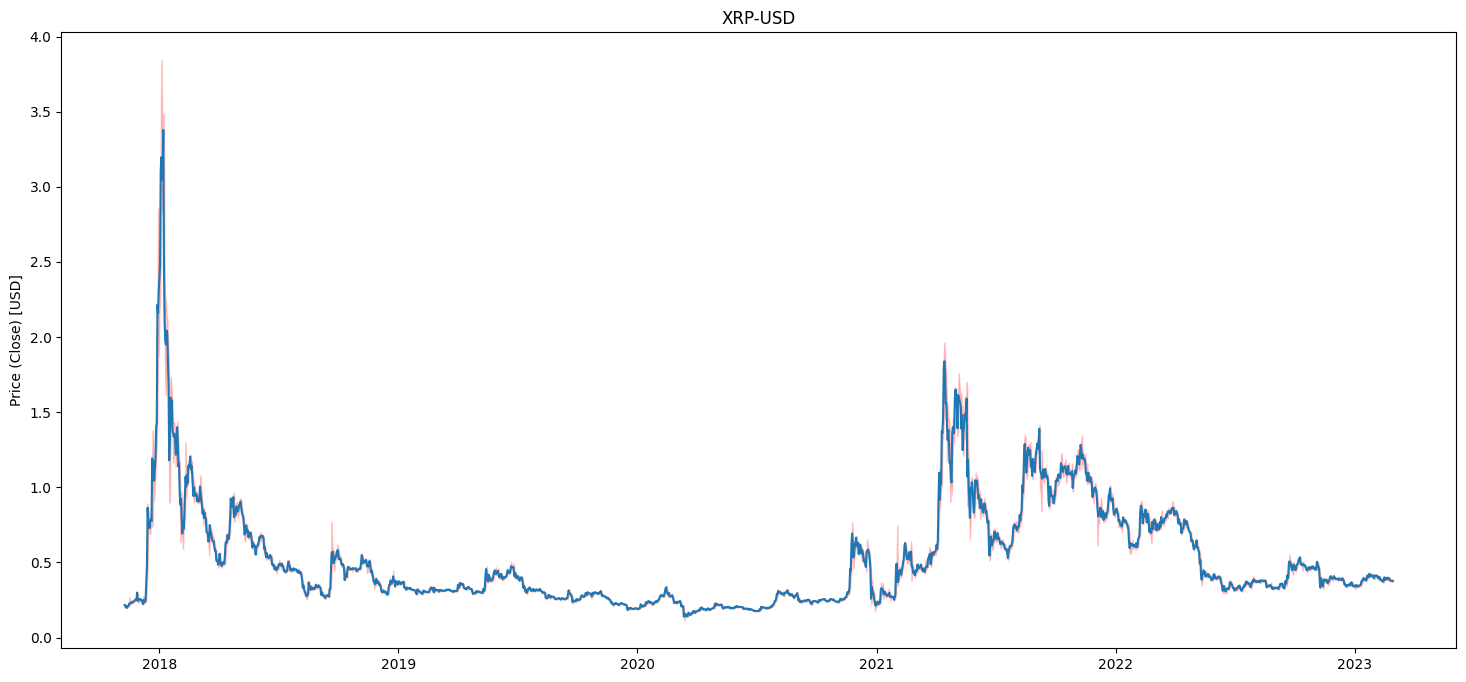

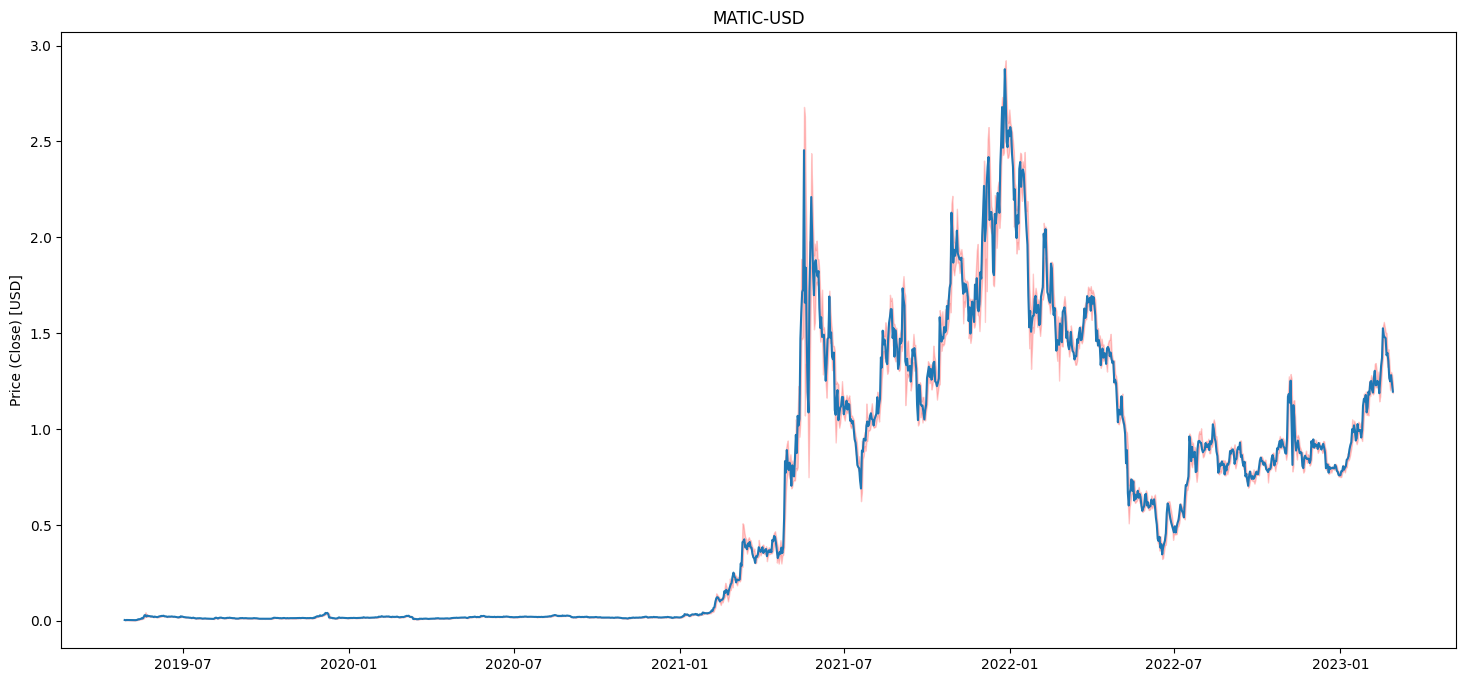

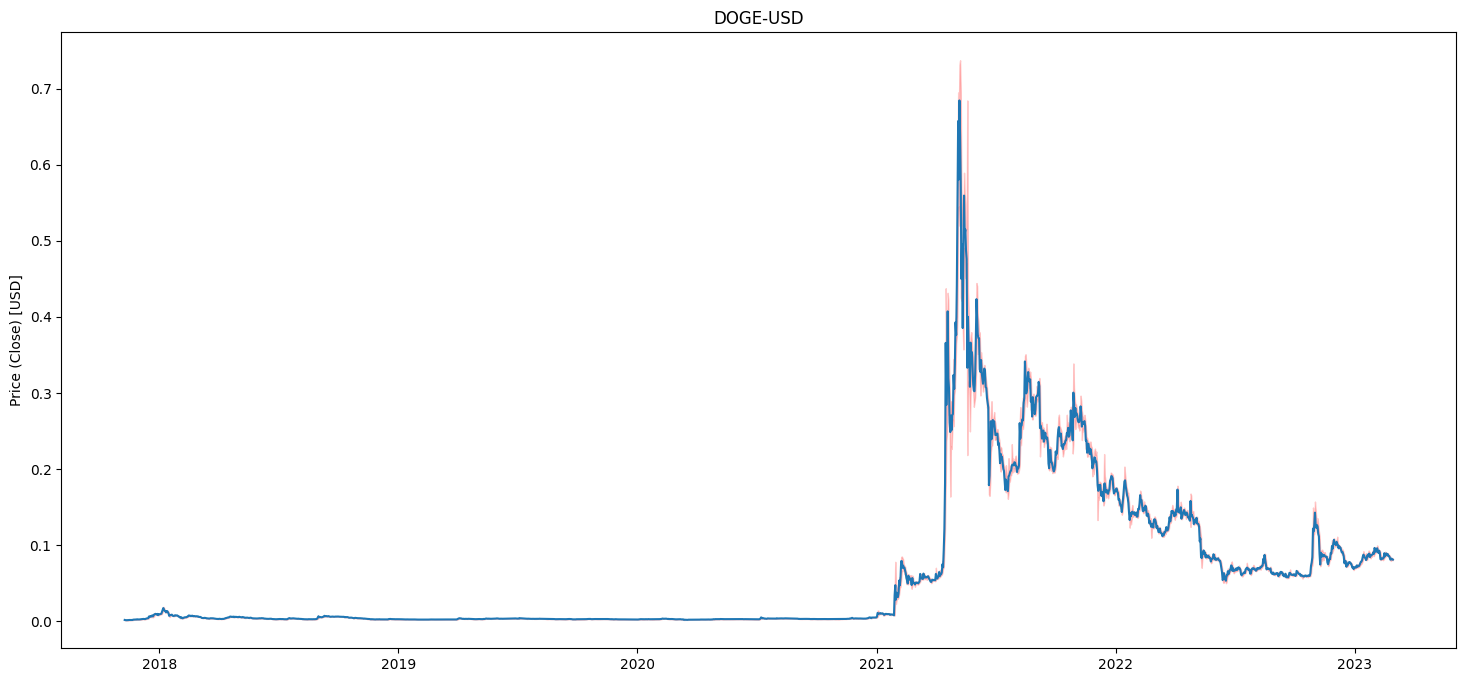

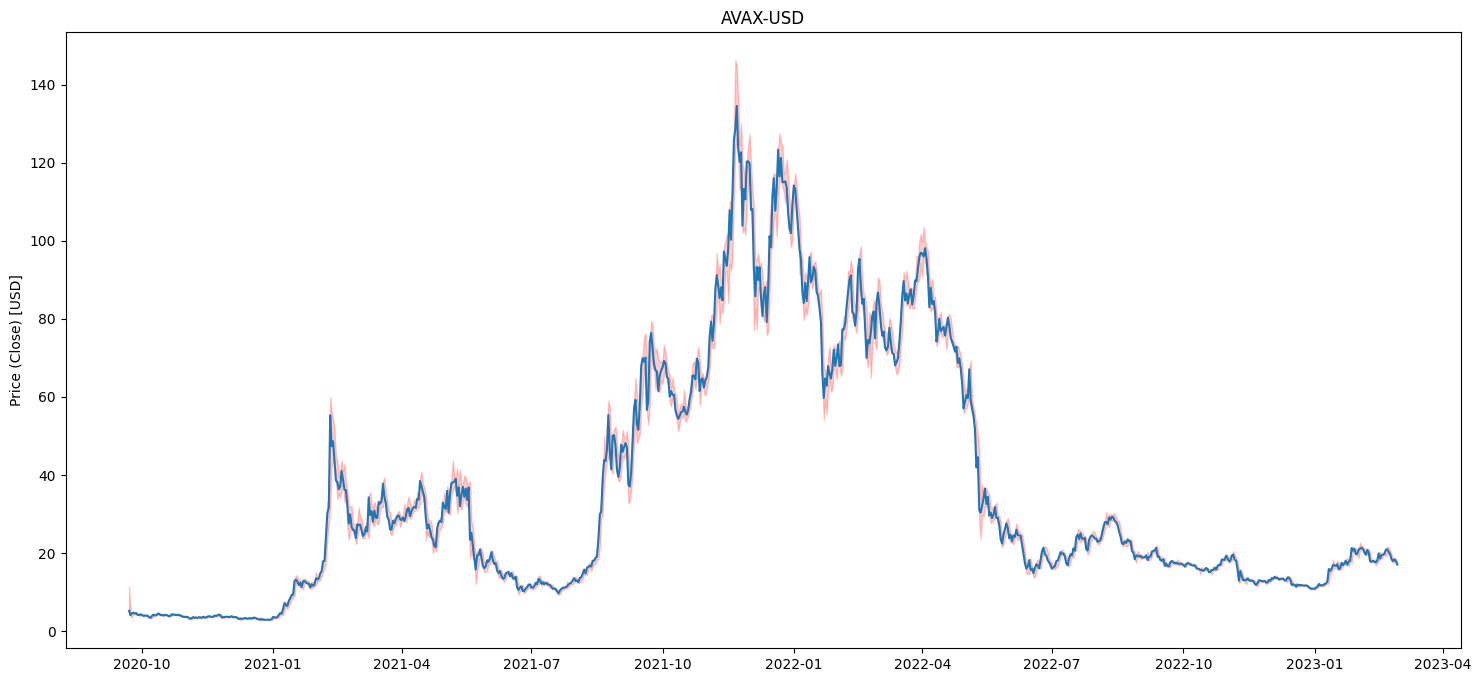

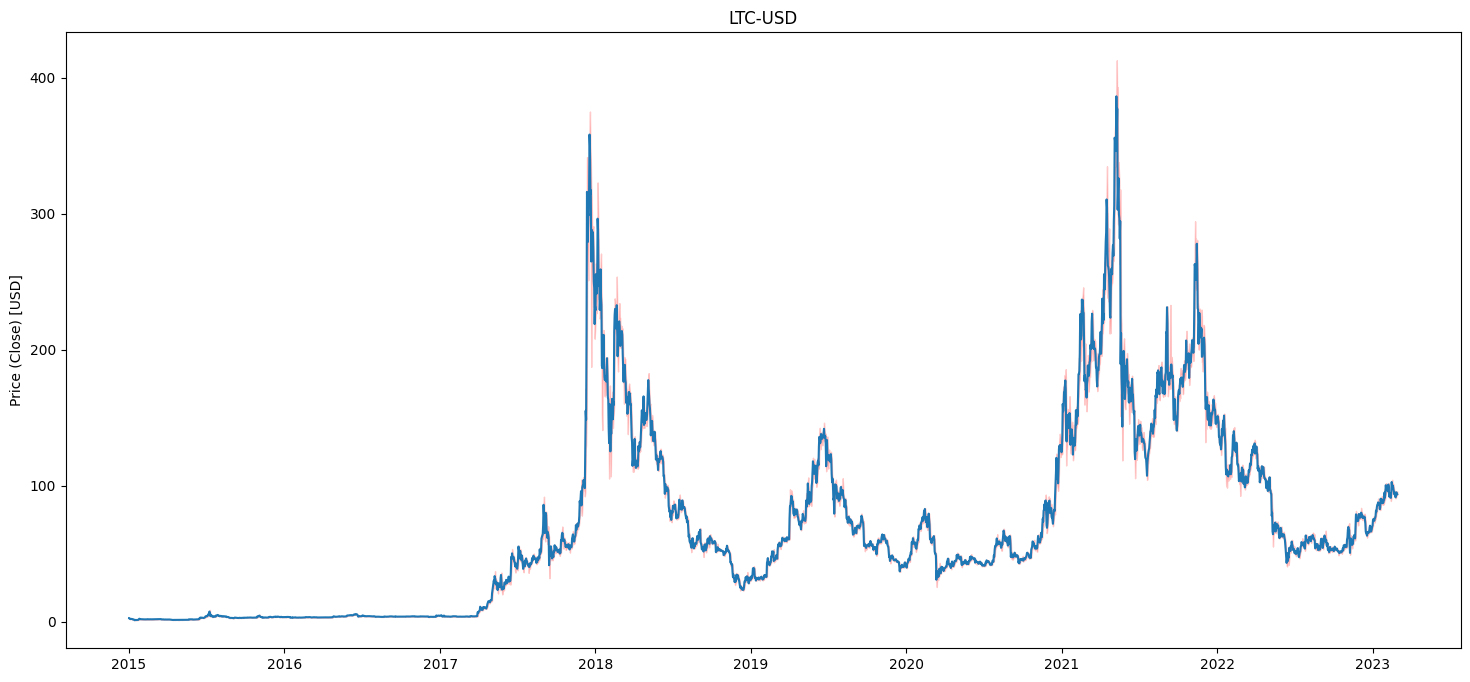

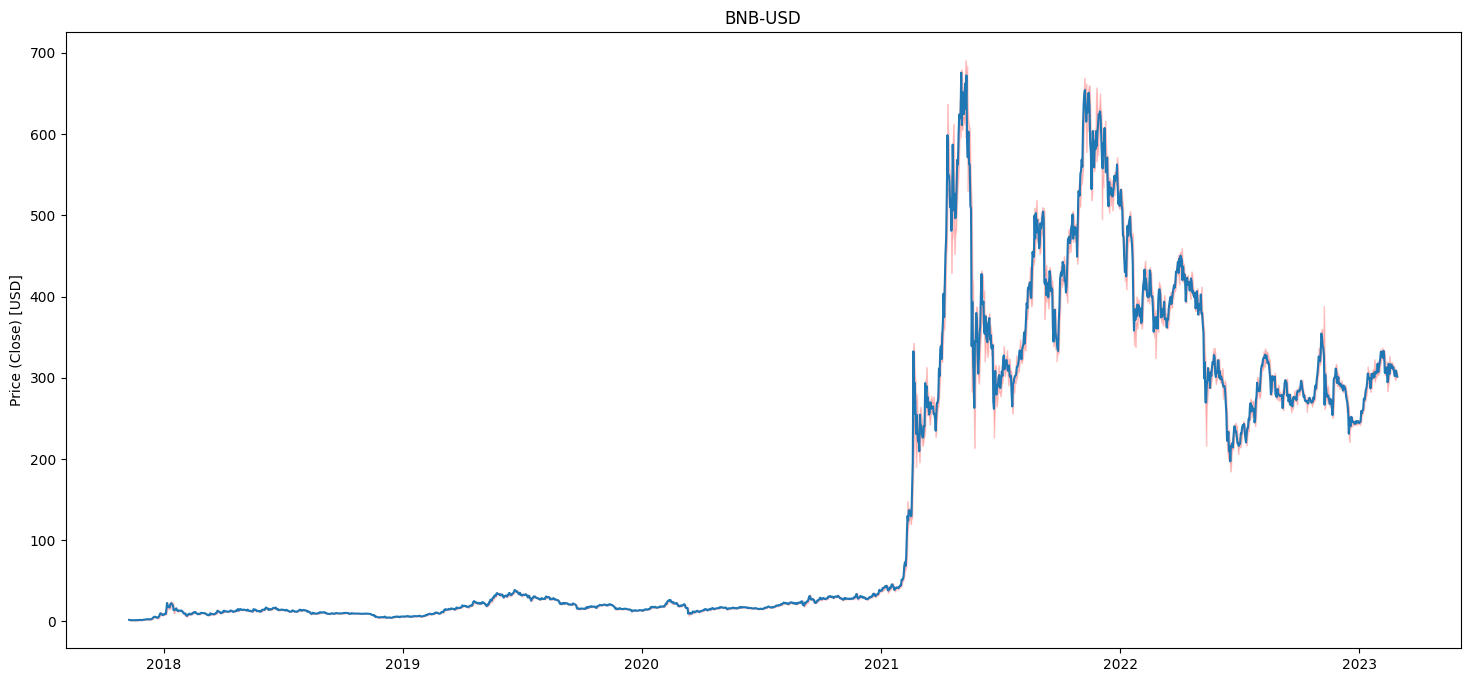

In [67]:
nrows = len(df_asset)
ncols = 1


for idx, (asset_name, df_asset) in enumerate(dict_assets.items()):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(18, 8))
    df_plot = df_asset#['2022-01-01': '2022-06-30']
    ax.plot(df_plot['Close'])

    ax.fill_between(
        df_plot.index, 
        df_plot['High'], 
        df_plot['Low'], 
        alpha=0.2,
        color='red',
        interpolate=False,
        )
    ax.set_title(asset_name)
    ax.set_ylabel("Price (Close) [USD]")
    
    plt.show()

Plot of close price trends of all assets

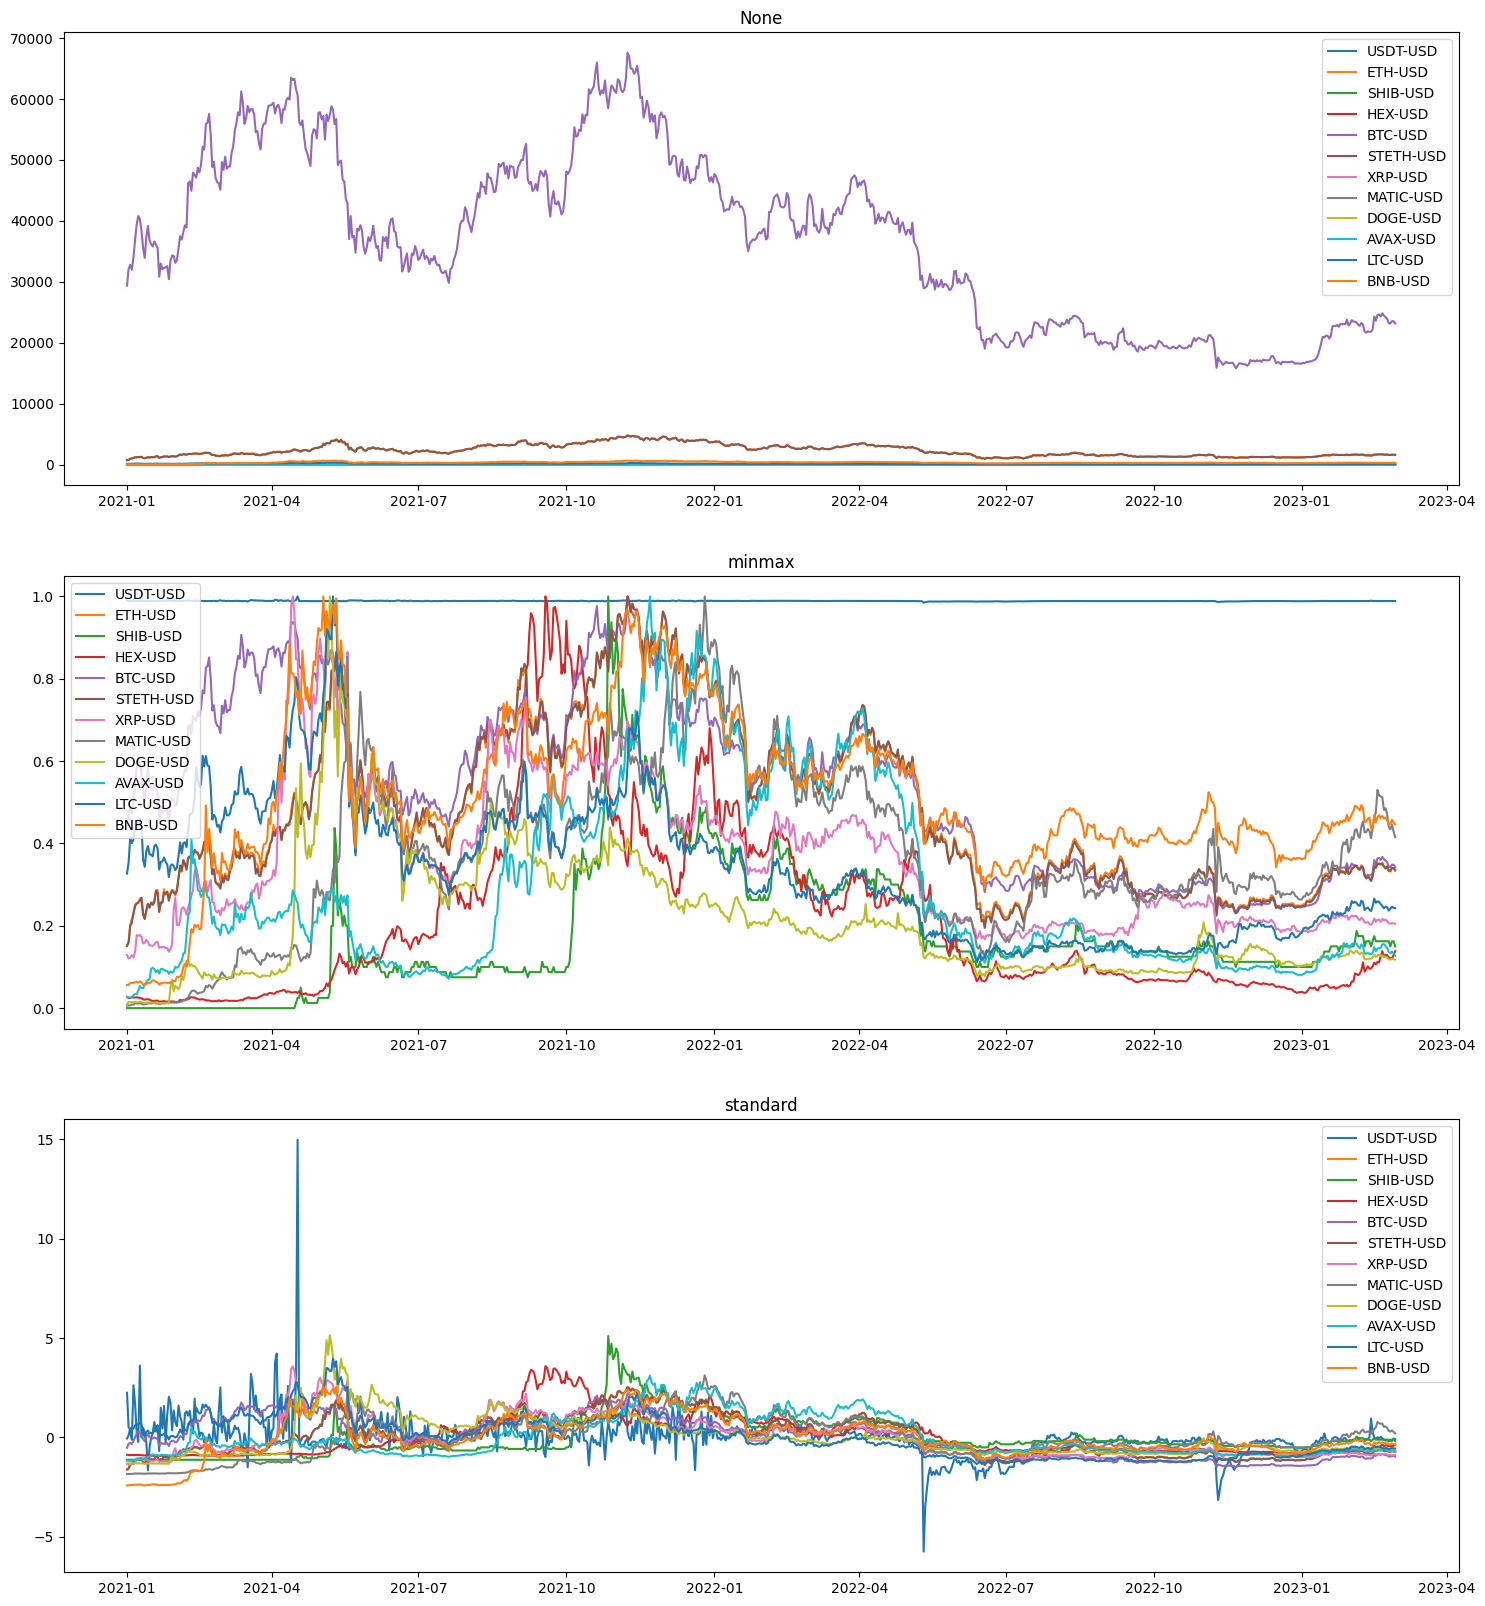

In [14]:
NORM = [None, 'minmax', 'standard']

nrows, ncols = len(NORM), 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(18, 20))

colormap = plt.cm.nipy_spectral
colors = colormap(np.linspace(0, 1, len(dict_assets)))
ax.set_prop_cycle('color', colors)

for idx, (asset_name, df_asset) in enumerate(dict_assets.items()):
    # if asset_name == 'BTC-USD':
    #     continue
    df_plot = df_asset['2021-01-01':]
    for idx, norm_method in enumerate(NORM):
        ax = axs[idx]
        

        if norm_method==None:
            ax.plot(df_plot['Close'], label=asset_name)
        
        elif norm_method=='minmax':
            ax.plot(df_plot['Close']/df_plot['Close'].max(), label=asset_name)
        elif norm_method=='standard':
            standard_scaler = StandardScaler()
            ax.plot(
                pd.Series(
                    standard_scaler.fit_transform(df_plot['Close'].values.reshape(-1, 1)).reshape(1,-1)[0],
                    index=df_plot['Close'].index
                    ), 
                    label=asset_name)
        ax.set_title(str(norm_method))
        ax.legend()
    
plt.show()

## Describe Returns

In [13]:
df_asset.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'daily_returns',
       'daily_volatility', 'daily_log_returns', 'daily_squared_returns',
       'monthly_realized_volatility', 'weekly_realized_volatility',
       'relative_price_range', 'money_flow_index',
       'avg_directional_movement_index', 'williams_accumulation_distribution',
       '^N225_Open', '^N225_High', '^N225_Low', '^N225_Close',
       '^N225_Adj_Close', '^N225_Volume', 'Tcm1mo', 'Tcm3mo', 'Tcm1yr',
       'Tcm5yr', 'Tcm10yr', 'S_P_500_index_Open', 'S_P_500_index_High',
       'S_P_500_index_Low', 'S_P_500_index_Close',
       'S_P_500_index_daily_returns', 'S_P_500_index_daily_log_returns',
       'S_P_500_index_monthly_realized_volatility', 'Tcm1mo', 'Tcm3mo',
       'Tcm1yr', 'Tcm5yr', 'Tcm10yr', '^IXIC_Open', '^IXIC_High', '^IXIC_Low',
       '^IXIC_Close', '^IXIC_Adj_Close', '^IXIC_Volume', 'Tcm1mo', 'Tcm3mo',
       'Tcm1yr', 'Tcm5yr', 'Tcm10yr', 'EURUSD=X_Open', 'EURUSD=X_High',
       'EURUSD=X_Lo

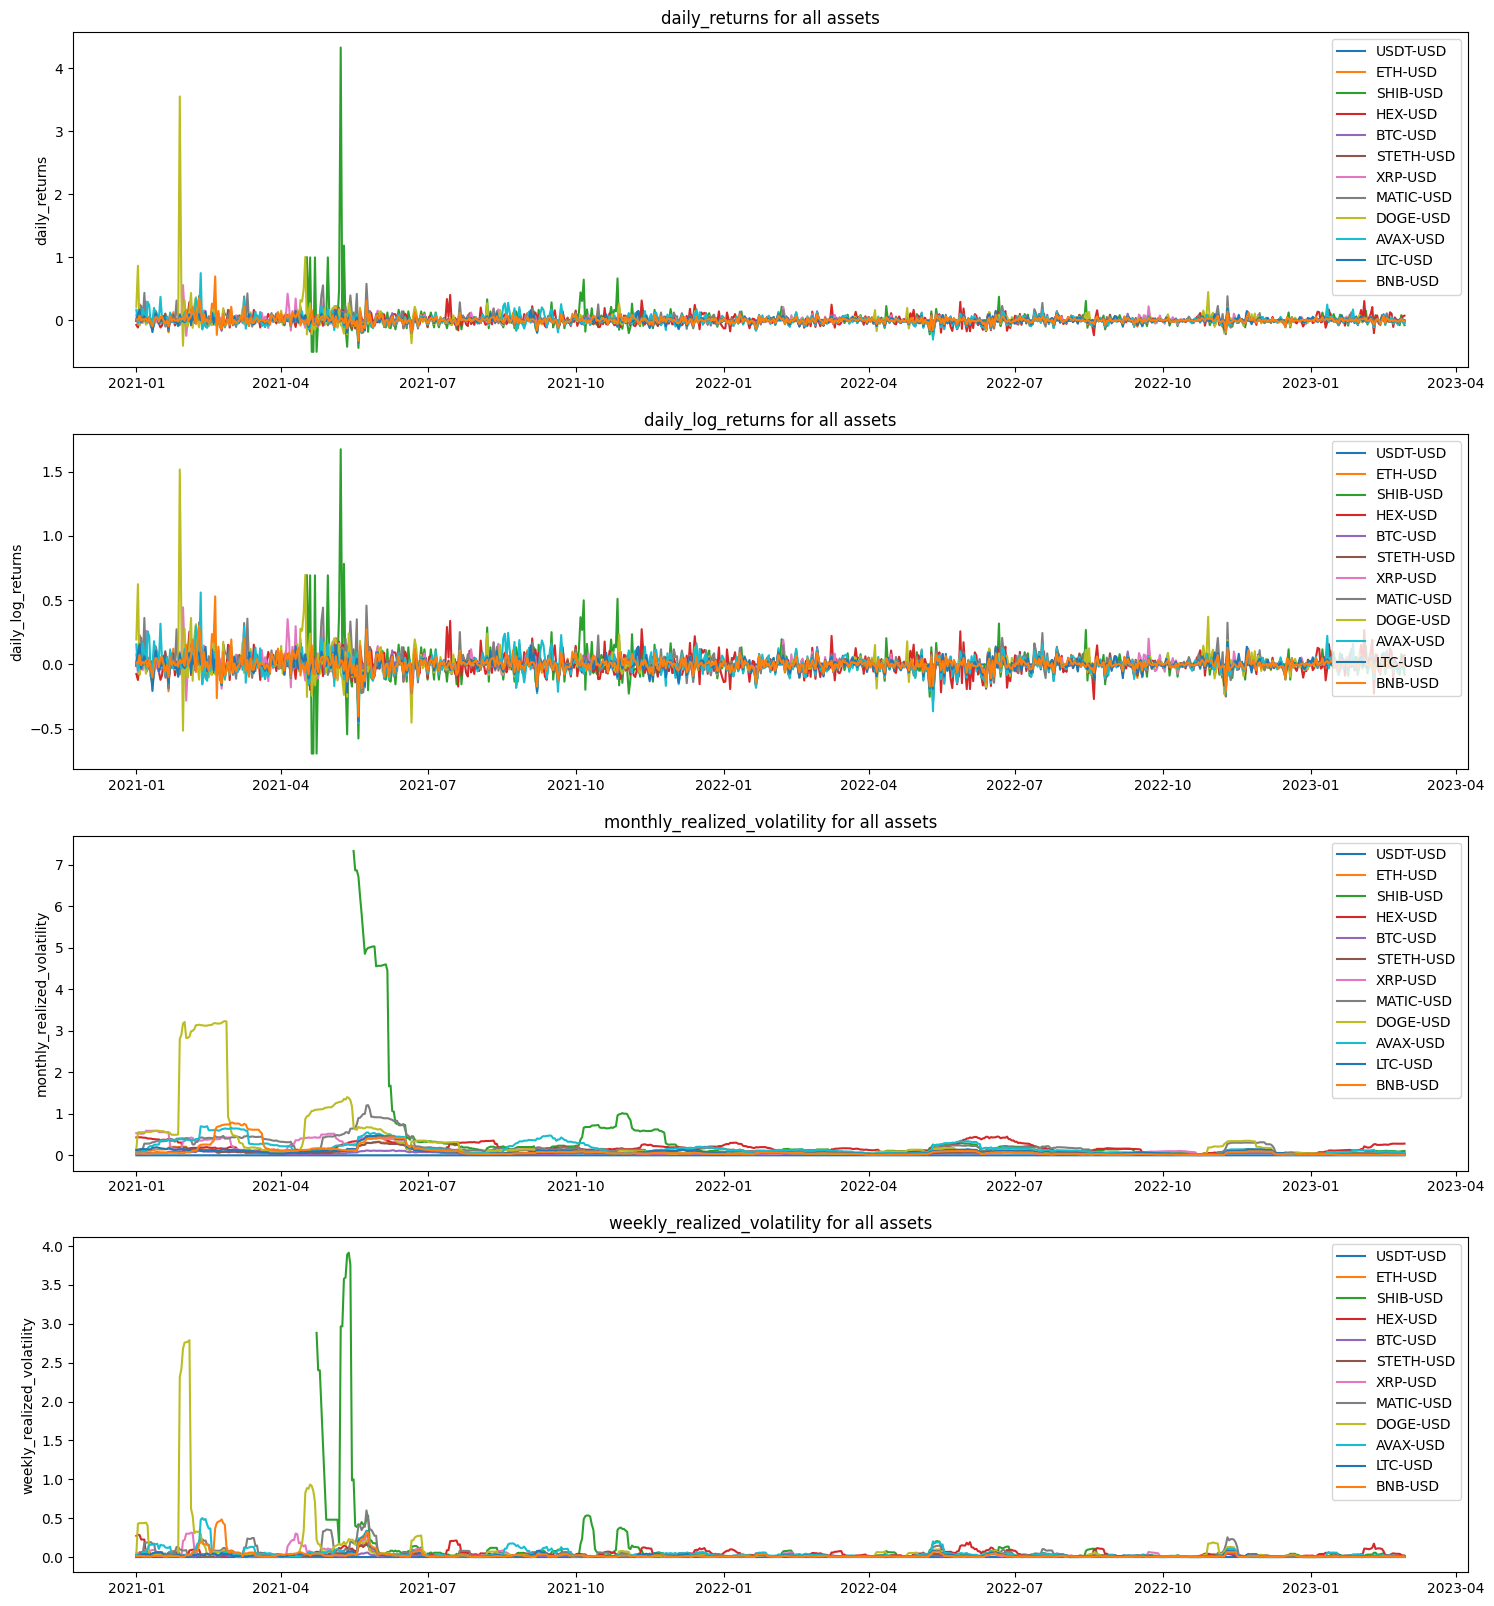

In [68]:
RETURN_VARS = ['daily_returns', 'daily_log_returns', 'monthly_realized_volatility', 'weekly_realized_volatility']

nrows, ncols = len(RETURN_VARS), 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(18, 20))

colormap = plt.cm.nipy_spectral
colors = colormap(np.linspace(0, 1, len(dict_assets)))
ax.set_prop_cycle('color', colors)

for idx, return_var in enumerate(RETURN_VARS):
    ax = axs[idx]
    for asset_name, df_asset in dict_assets.items():
        # if asset_name == 'BTC-USD':
        #     continue
        df_plot = df_asset['2021-01-01':]
        ax.plot(df_plot[return_var], label=asset_name)
        
    ax.set_title(f"{str(return_var)} for all assets")
    ax.set_ylabel(str(return_var))
    ax.legend(loc='upper right')
    
plt.show()

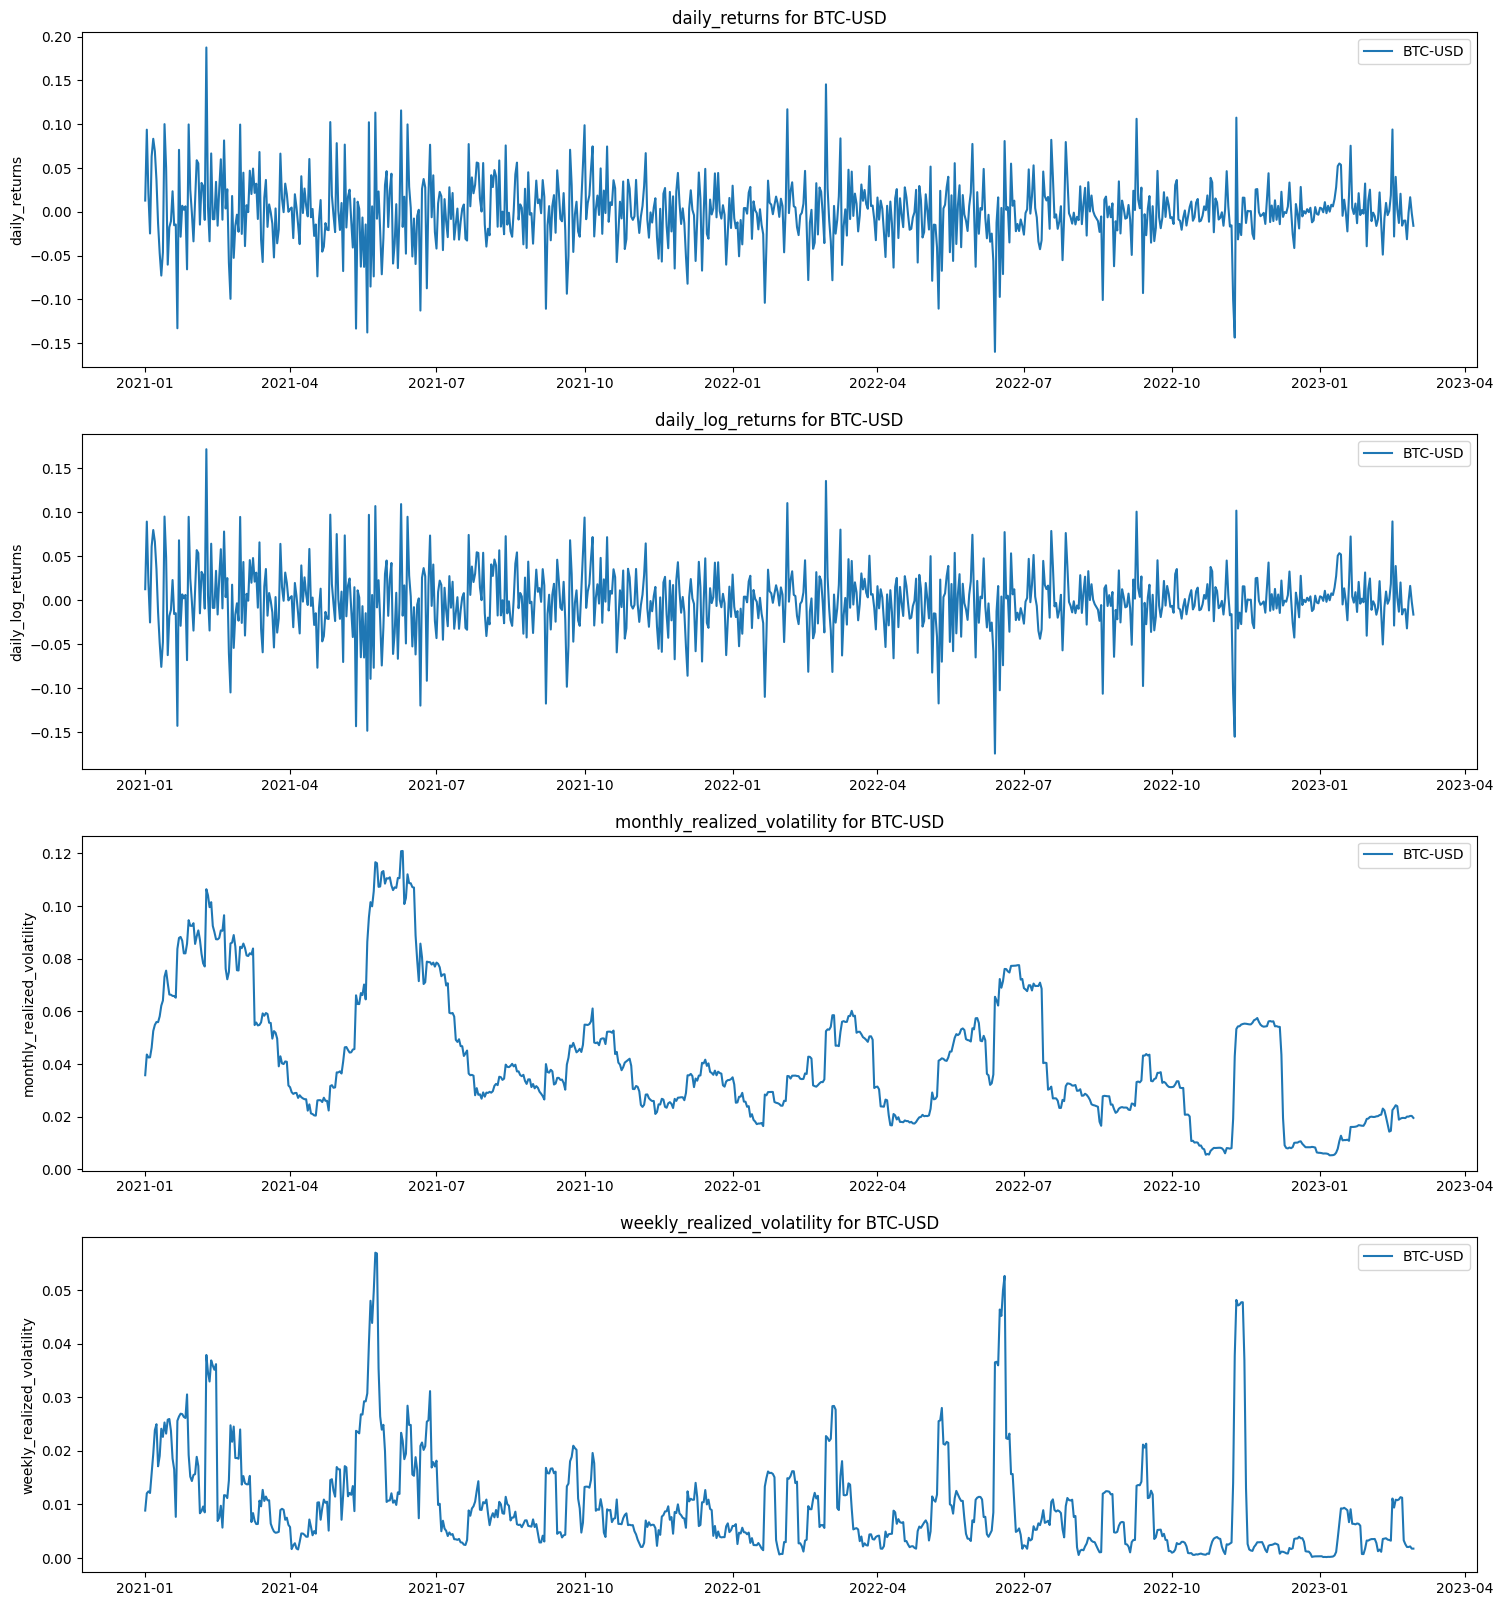

In [17]:
RETURN_VARS = ['daily_returns', 'daily_log_returns', 'monthly_realized_volatility', 'weekly_realized_volatility']
ASSET_NAME = 'BTC-USD'

nrows, ncols = len(RETURN_VARS), 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(18, 20))

colormap = plt.cm.nipy_spectral
colors = colormap(np.linspace(0, 1, len(dict_assets)))
ax.set_prop_cycle('color', colors)

for idx, return_var in enumerate(RETURN_VARS):
    ax = axs[idx]
    df_asset = dict_assets[ASSET_NAME]
    df_plot = df_asset['2021-01-01':]
    ax.plot(df_plot[return_var], label=ASSET_NAME)

    ax.set_title(f"{str(return_var)} for {ASSET_NAME}")
    ax.set_ylabel(str(return_var))
    ax.legend()

plt.show()

## Correlation

Correlations between explanatory variables of each asset

In [16]:
df_asset = dict_assets['BTC-USD']

<Axes: >

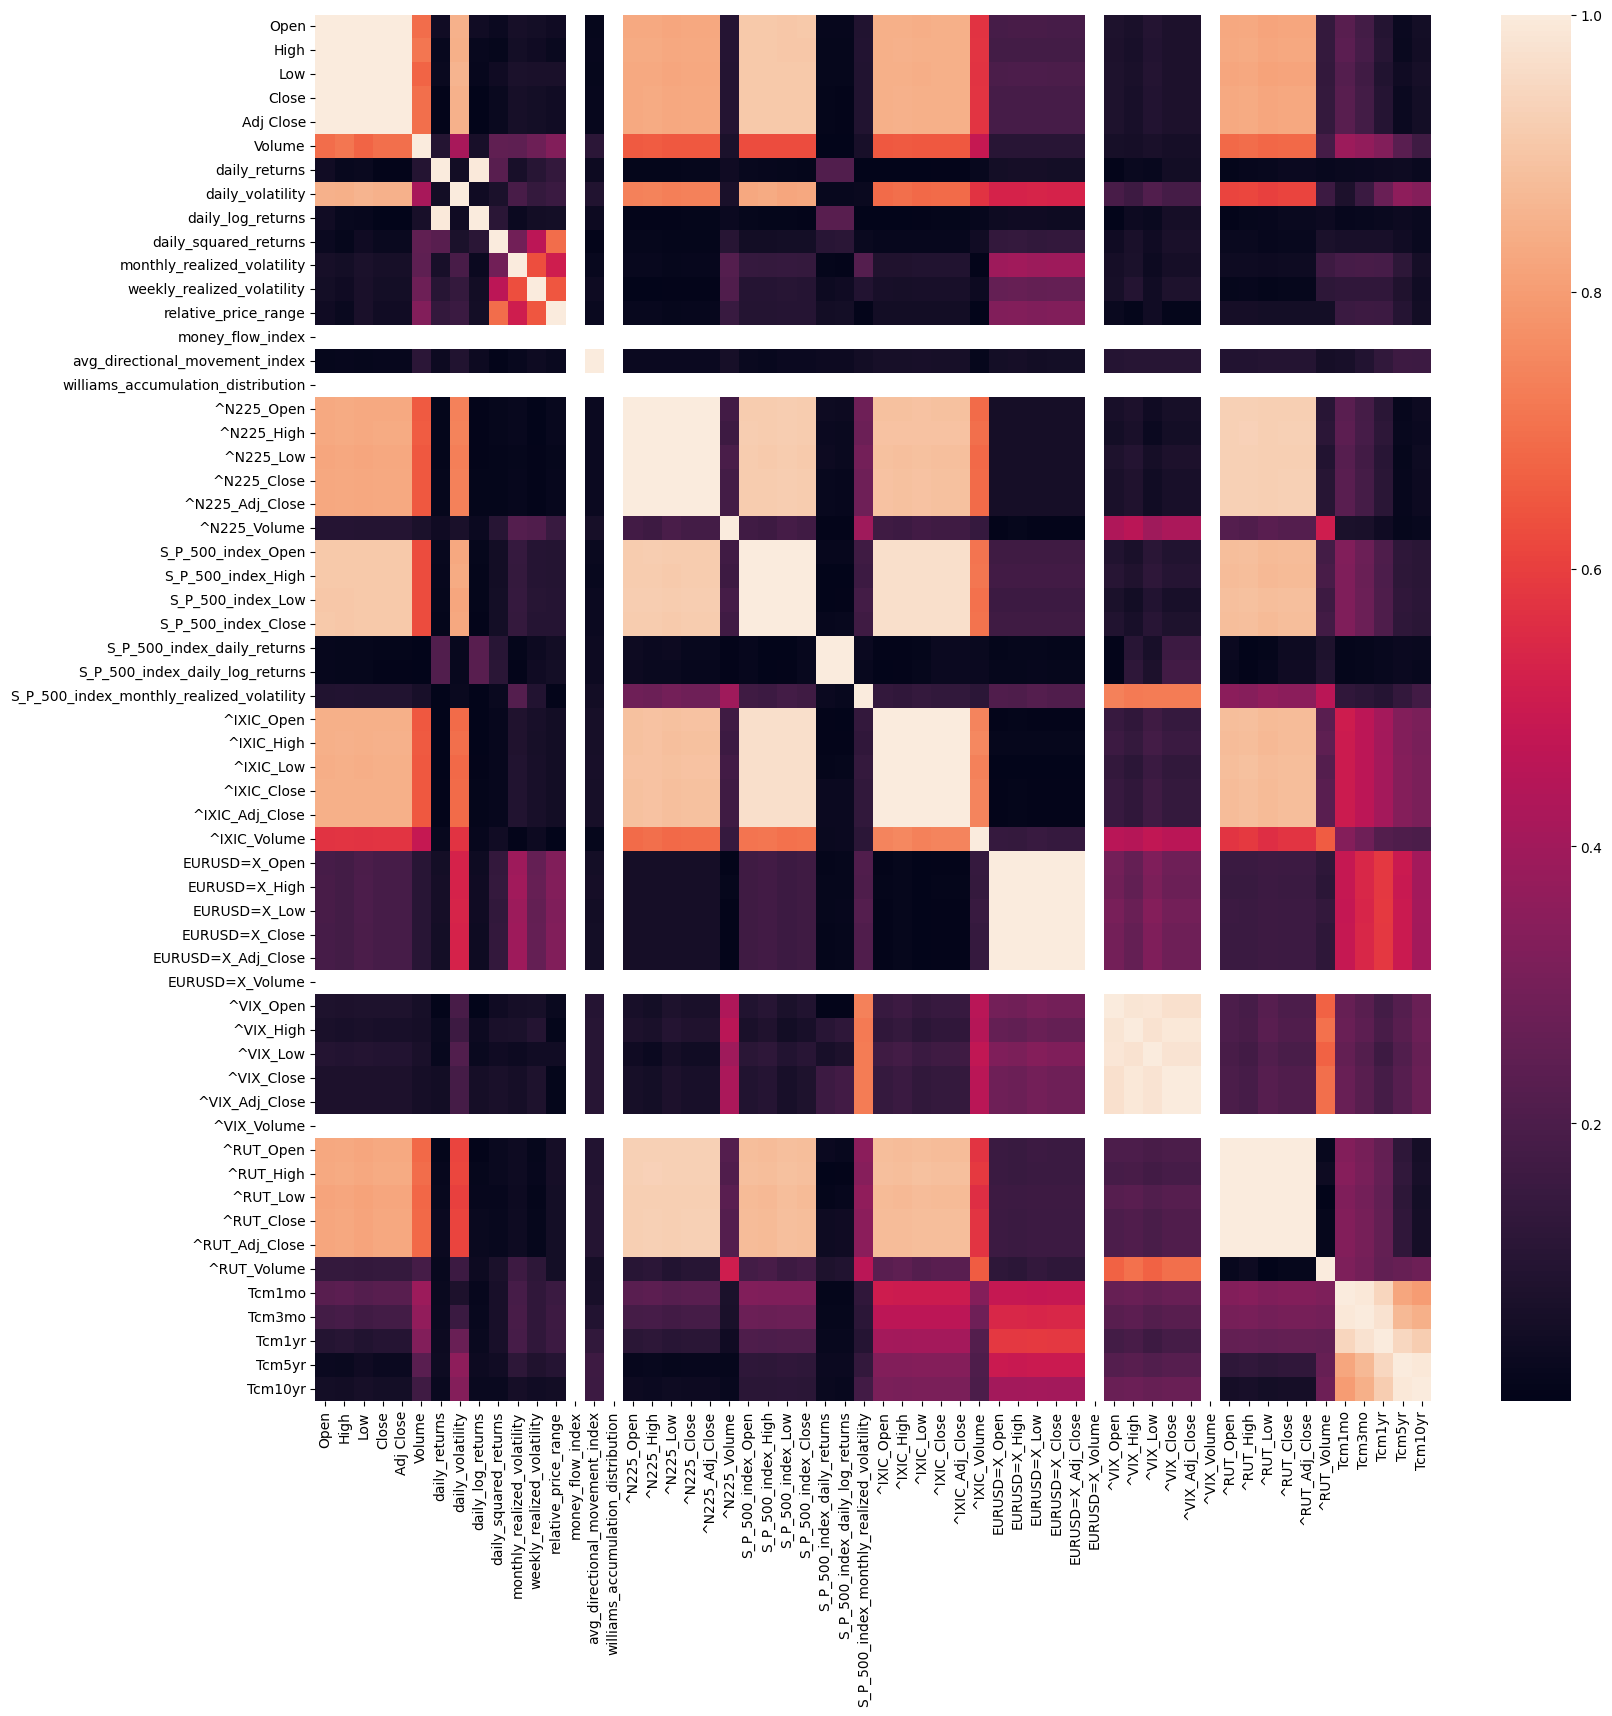

In [13]:
df_asset_corr = abs(df_asset['2015-01-01':].corr())

plt.figure(figsize=(18, 18))
sns.heatmap(
    df_asset_corr,
    xticklabels=df_asset_corr.columns,
    yticklabels=df_asset_corr.columns,
    ax=plt.gca()
)

<Axes: >

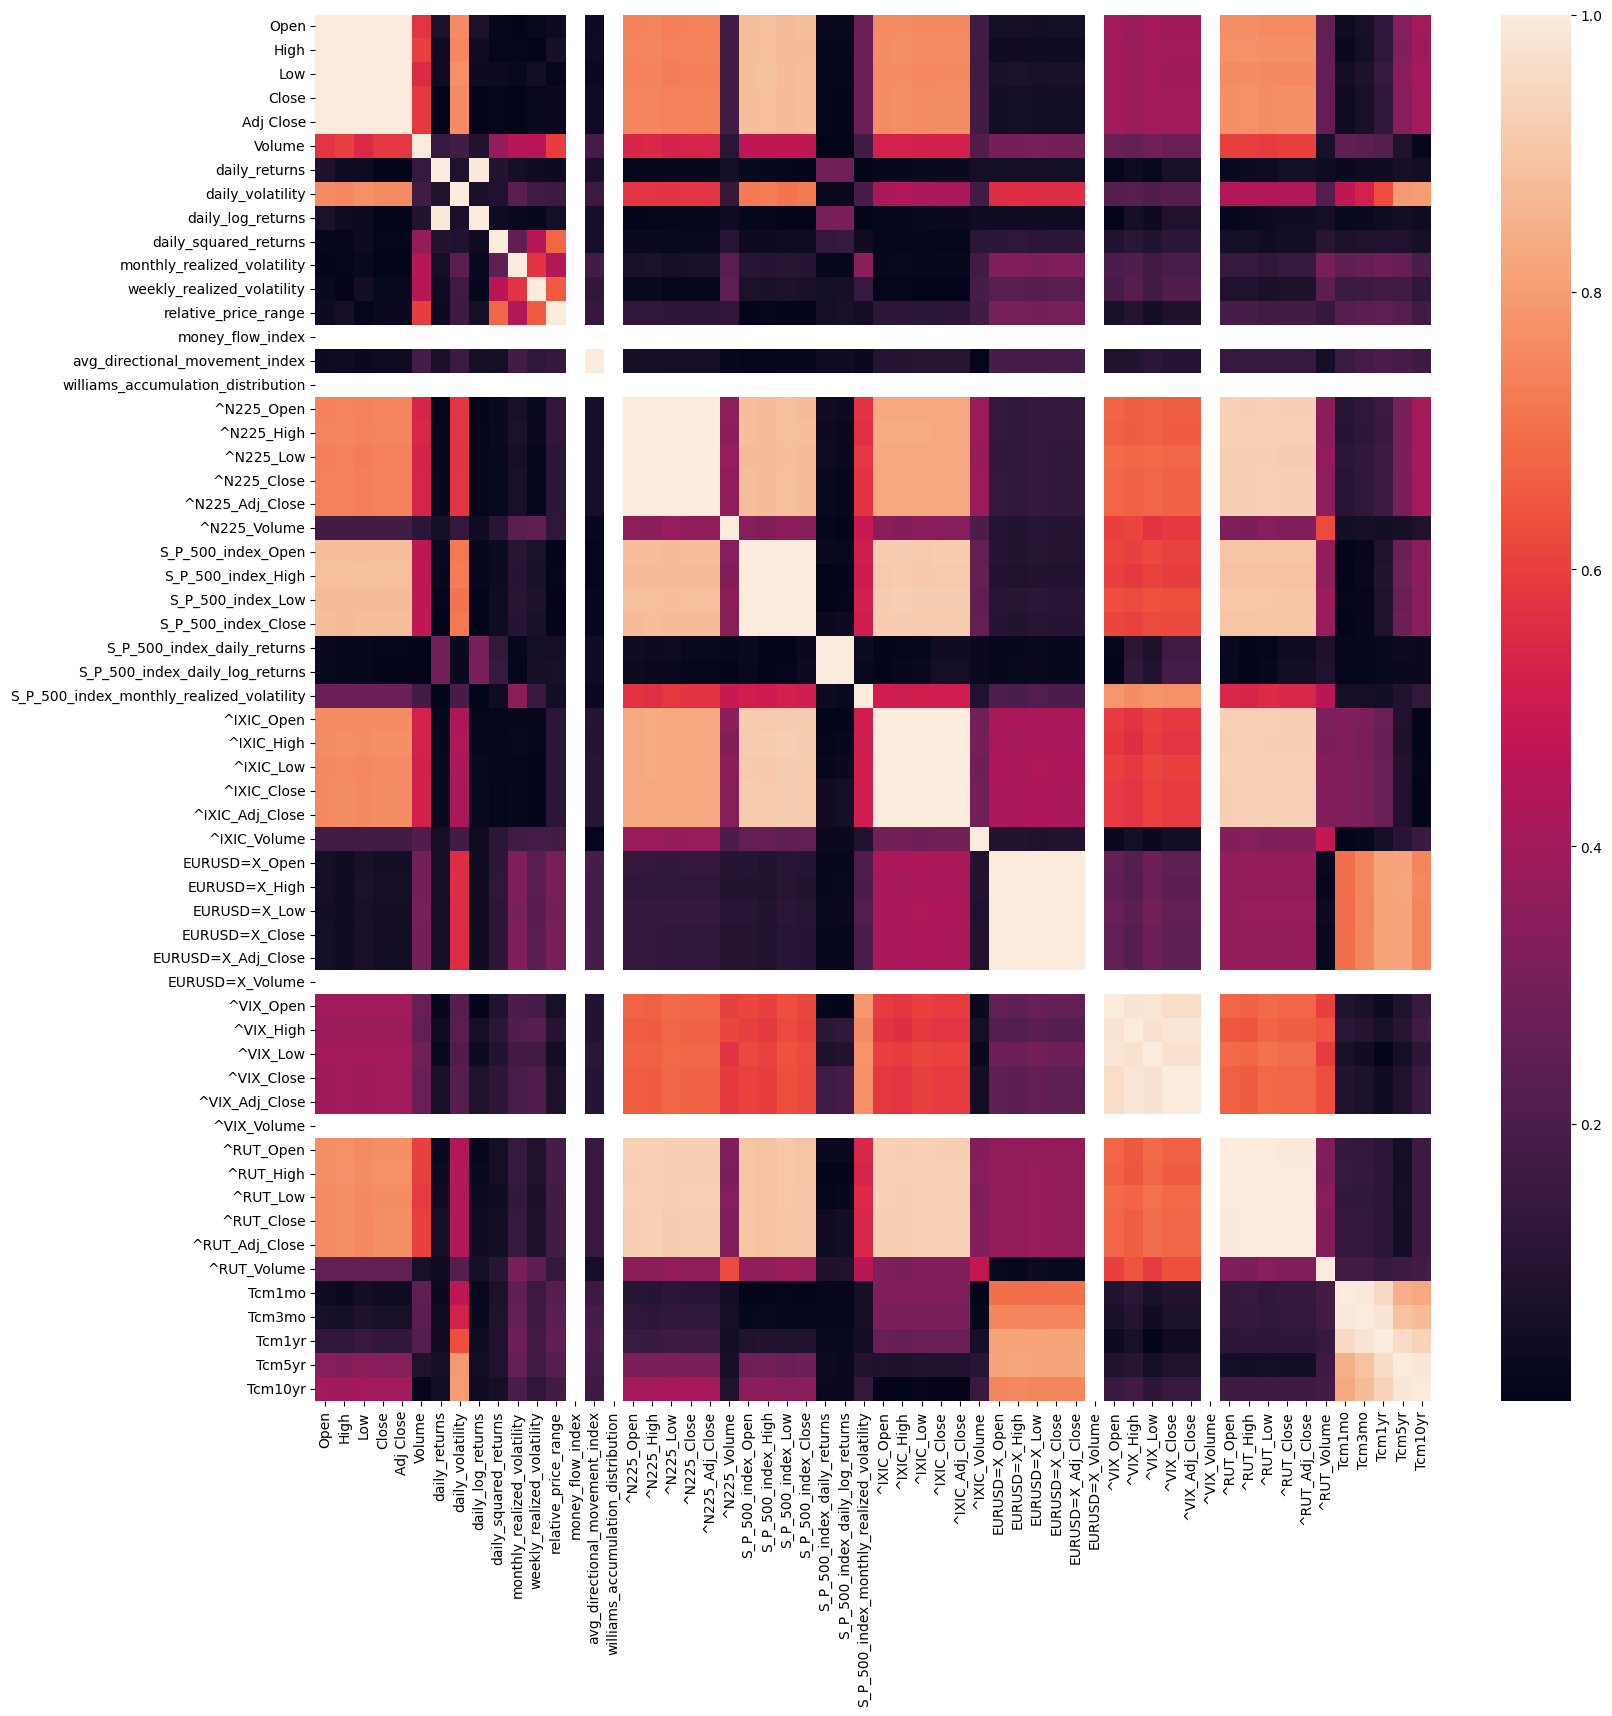

In [14]:
df_asset_corr = abs(df_asset['2020-01-01':].corr())

plt.figure(figsize=(18, 18))
sns.heatmap(
    df_asset_corr,
    xticklabels=df_asset_corr.columns,
    yticklabels=df_asset_corr.columns,
    ax=plt.gca()
)

<Axes: >

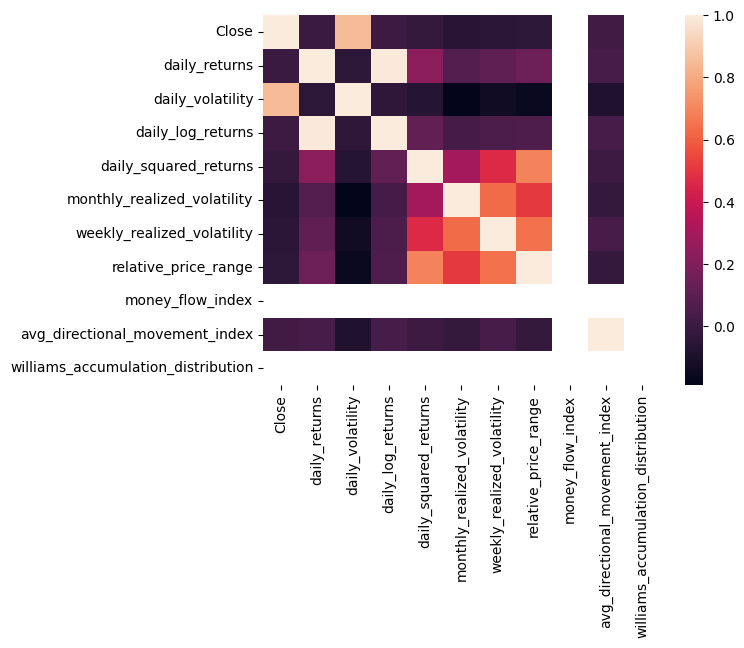

In [15]:
CALC_FEATS = [
    'daily_returns','daily_volatility', 'daily_log_returns', 'daily_squared_returns',
    'monthly_realized_volatility', 'weekly_realized_volatility', 'relative_price_range', 
    'money_flow_index', 'avg_directional_movement_index', 'williams_accumulation_distribution'
    ]

df_asset_corr = df_asset[['Close'] + CALC_FEATS].corr()

sns.heatmap(
    df_asset_corr,
    xticklabels=df_asset_corr.columns,
    yticklabels=df_asset_corr.columns,
)

<Axes: >

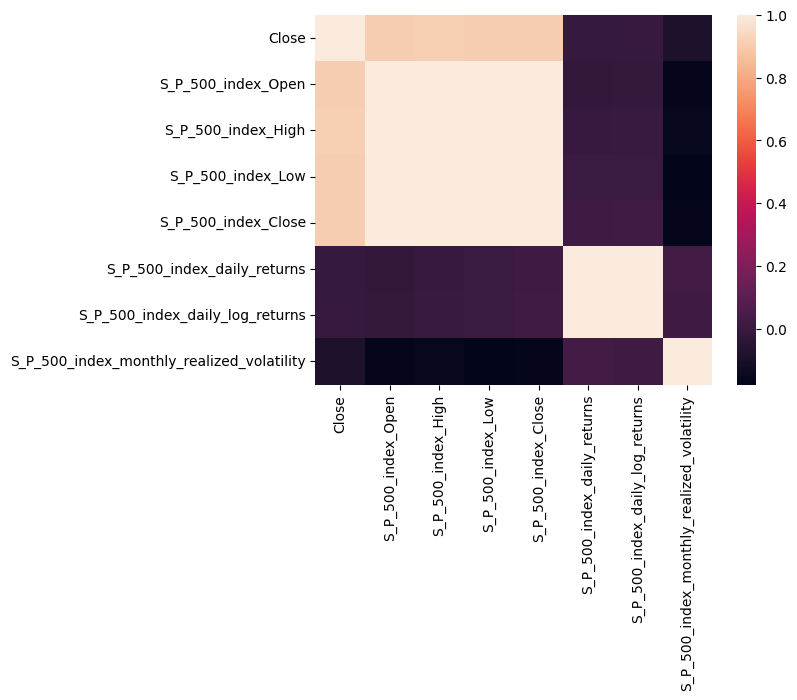

In [16]:
CALC_FEATS = [col for col in df_asset.columns if 'S_P_500' in col]

df_asset_corr = df_asset[['Close'] + CALC_FEATS].corr()

sns.heatmap(
    df_asset_corr,
    xticklabels=df_asset_corr.columns,
    yticklabels=df_asset_corr.columns,
)

<Axes: >

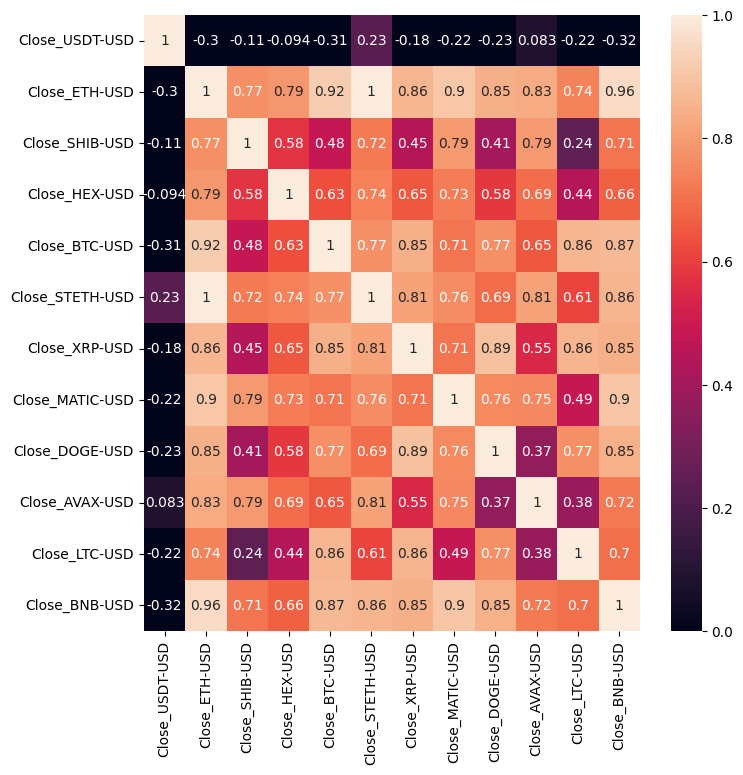

In [19]:
df_close_all_assets = pd.concat([df_asset['Close'].rename(f"Close_{asset_name}") for asset_name, df_asset in dict_assets.items()], axis=1)


TIME_PERIOD_START = '2019-01-01'
TIME_PERIOD_END = None #'2023-01-01'

if TIME_PERIOD_START:
    df_close_all_assets = df_close_all_assets[TIME_PERIOD_START:]
if TIME_PERIOD_END:
    df_close_all_assets = df_close_all_assets[:TIME_PERIOD_END]

df_all_asset_corr = df_close_all_assets.corr()

plt.figure(figsize=(8, 8))
sns.heatmap(
    df_all_asset_corr,
    xticklabels=df_all_asset_corr.columns,
    yticklabels=df_all_asset_corr.columns,
    annot=df_all_asset_corr.values,
    ax=plt.gca(),
    vmin=0,
)

<Axes: >

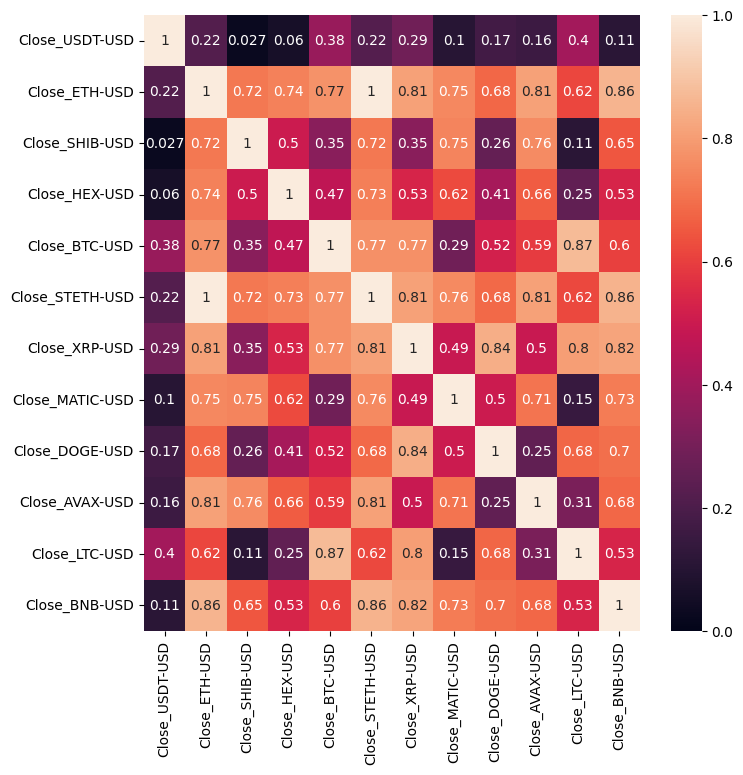

In [20]:
df_close_all_assets = pd.concat([df_asset['Close'].rename(f"Close_{asset_name}") for asset_name, df_asset in dict_assets.items()], axis=1)


TIME_PERIOD_START = '2021-01-01'
TIME_PERIOD_END = None #'2023-01-01'

if TIME_PERIOD_START:
    df_close_all_assets = df_close_all_assets[TIME_PERIOD_START:]
if TIME_PERIOD_END:
    df_close_all_assets = df_close_all_assets[:TIME_PERIOD_END]

df_all_asset_corr = df_close_all_assets.corr()

plt.figure(figsize=(8, 8))
sns.heatmap(
    df_all_asset_corr,
    xticklabels=df_all_asset_corr.columns,
    yticklabels=df_all_asset_corr.columns,
    annot=df_all_asset_corr.values,
    ax=plt.gca(),
    vmin=0,
)

In [22]:
df_close_btc_eth = pd.concat(
    [
        dict_assets['BTC-USD']['Close'].rename("Close_BTC-USD"), 
        dict_assets['ETH-USD']['Close'].rename("Close_ETH-USD"), 
    ], 
    axis=1,
)
df_close_btc_eth = df_close_btc_eth.dropna()
df_close_btc_eth = df_close_btc_eth.resample('1D').first()

corr_btc_eth_mean = pearsonr(df_close_btc_eth['Close_BTC-USD'], df_close_btc_eth['Close_ETH-USD']).statistic
corr_btc_eth_60d_roll = df_close_btc_eth['Close_BTC-USD'].rolling('60D', min_periods=60).corr(df_close_btc_eth['Close_ETH-USD'])

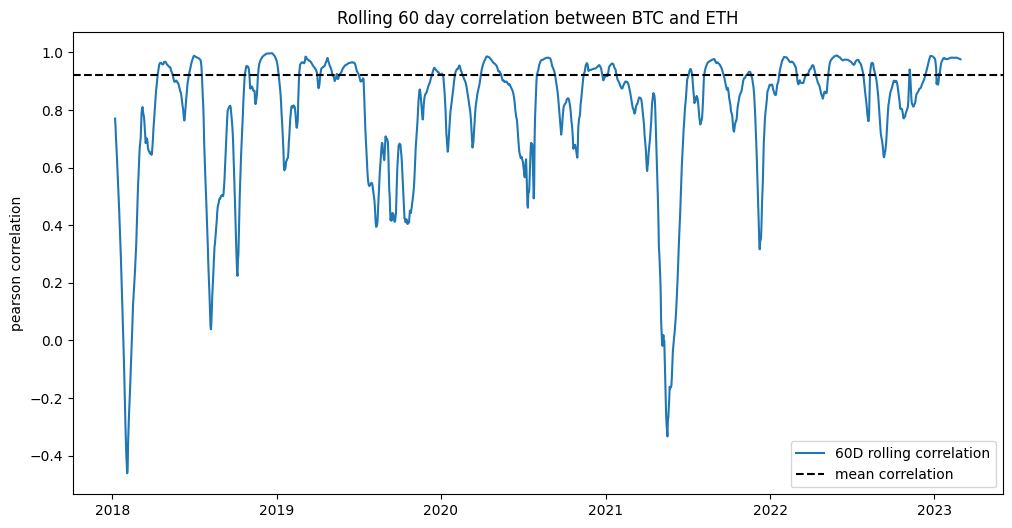

In [23]:
plt.figure(figsize=(12,6))
plt.plot(corr_btc_eth_60d_roll, label='60D rolling correlation')
plt.axhline(corr_btc_eth_mean, color='black', ls='--', label='mean correlation')

plt.title("Rolling 60 day correlation between BTC and ETH")
plt.ylabel("pearson correlation")
plt.legend()

## Descriptive Stats
N, min value, 1st quantile, median, mean, standard deviation, 3rd quantile, max value, skewness, kurtosis

In [27]:
pd.options.display.max_columns = 100

In [30]:
df_close_all_assets = pd.concat([df_asset['Close'].rename(f"Close_{asset_name}") for asset_name, df_asset in dict_assets.items()], axis=1)

df_descriptive_stats = pd.concat([
    df_close_all_assets.describe(), 
    pd.DataFrame(df_close_all_assets.kurtosis(), columns=['kurtosis']).T,
    pd.DataFrame(df_close_all_assets.skew(), columns=['skewness']).T,
])
df_descriptive_stats

Close_USDT-USD  Close_ETH-USD  Close_SHIB-USD  Close_HEX-USD  \
count        1938.000000    1938.000000      942.000000    1170.000000   
mean            1.001530    1142.440624        0.000012       0.072589   
std             0.005627    1172.103874        0.000013       0.099617   
min             0.966644      84.308296        0.000000       0.000015   
25%             0.999984     213.643108        0.000000       0.004417   
50%             1.000427     559.634278        0.000009       0.031108   
75%             1.002341    1718.111817        0.000014       0.118020   
max             1.077880    4812.087402        0.000080       0.486741   
kurtosis       29.024788       0.361284        3.658576       3.439953   
skewness        2.323488       1.179694        1.686643       1.903639   

          Close_BTC-USD  Close_STETH-USD  Close_XRP-USD  Close_MATIC-USD  \
count       2981.000000       798.000000    1938.000000      1403.000000   
mean       13481.524369      2279.307247       0.520195         0.613767   
std        16181.118403       990.257740       0.359689         0.680563   
min          178.102997       588.655334       0.139635         0.003141   
25%          920.382019      1488.395416       0.288724         0.018624   
50%         7556.237793      1957.515686       0.388867         0.359934   
75%        19044.107422      3045.659729       0.656891         1.099234   
max        67566.828125      4777.916992       3.377810         2.876757   
kurtosis       1.130637        -0.729478       9.853790        -0.416269   
skewness       1.472561         0.591856       2.419911         0.806150   

          Close_DOGE-USD  Close_AVAX-USD  Close_LTC-USD  Close_BNB-USD  
count        1938.000000      890.000000    2981.000000    1938.000000  
mean            0.061479       35.406078      69.656052     151.493394  
std             0.096918       30.949859      66.984527     182.006423  
min             0.001038        2.906161       1.157010       1.510360  
25%             0.002607       13.236840       4.219910      14.418800  
50%             0.004278       21.129919      54.807610      27.617919  
75%             0.083464       57.403381     100.378006     299.277535  
max             0.684777      134.531036     386.450775     675.684082  
kurtosis        5.476477        0.069260       1.653547      -0.460489  
skewness        2.149411        1.096685       1.291831       0.933893